In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
import re
import string
import tensorflow as tf
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')


In [2]:
class CommentClassifier():
    def __init__(self, category, classifier, classifierType):
        self.category = category
        self.classifier = classifier
        self.classifierType = classifierType

    def setScore(self, score):
        self.score = score

# ---------------------------------------------

# For text cleaning
def remove_punct(input_text):
    result = input_text.translate(str.maketrans("", "", string.punctuation))
    return result

def remove_URL(input_text):
    result = re.sub(r"https?://\S+|www\.\S+","", input_text)
    return result

def remove_html(input_text):
    result = re.sub(r"<.*?>","",input_text)
    return result

def remove_tokens(input_text):
    result = re.sub(r"\n|\r|\t", "", input_text)
    return result

# ---------------------------------------------
# Word counting method - for neural network
def word_counter(text):
    unique_word_counter = Counter()
    word_counts = []
    for i in text.values:
        text_word_count = 0
        for word in i.split():
            text_word_count += 1
            unique_word_counter[word] += 1
        word_counts.append(text_word_count)
    return word_counts, unique_word_counter

def init_params(labels):
    class_biases = []
    class_weights = []

    for (columnName, columnData) in labels.iteritems():
        neg, pos = np.bincount(columnData)
        total = neg + pos
        class_prop = pos/total
        print('Class {}:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
            columnName, total, pos, 100 * class_prop))
        bias = np.log([pos/neg])
        weight = 1/class_prop
        print(weight)
        print()
        class_biases.append(bias)
        class_weights.append(weight)

    return class_biases, class_weights

# Method for fitting and validating
def fit_predict(features, target, targetName, classifier, classifierList, classifierType):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state=2)
    classifierObj = CommentClassifier(targetName, classifier, classifierType)
    print("Training ",targetName, " category ...")
    classifierObj.classifier.fit(X_train, y_train)
    validation_pred = classifierObj.classifier.predict_proba(X_test)

    scorer = tf.keras.metrics.AUC()
    scorer.update_state(validation_pred[:,1], y_test)
    validation_auc = (scorer.result().numpy())*100

    validation_acc = classifierObj.classifier.score(X_test, y_test)
    print()
    classifierList.append(classifierObj)

    return validation_auc, validation_acc

# Method for testing model
def predict_score(classifierObjList, features, labels, training_auc, training_acc):
    test_predictions = np.zeros(labels.shape)
    test_pred_classes = np.zeros(labels.shape)
    testing_auc_total = 0
    testing_prec_total = 0

    for index, classifierObj in enumerate(classifierObjList):
        y_pred = (classifierObj.classifier.predict_proba(features))
        y_pred_classes = (classifierObj.classifier.predict(features))
        testing_scorer_auc = tf.keras.metrics.AUC()
        testing_scorer_auc.update_state(y_pred[:,1], labels.iloc[:,index])
        auc_score = (testing_scorer_auc.result().numpy())*100
        testing_auc_total += auc_score

        test_pred_classes[:,index] = y_pred_classes

        testing_scorer_rec = tf.keras.metrics.Precision()
        testing_scorer_rec.update_state(y_pred_classes, labels.iloc[:,index])
        rec_score = (testing_scorer_rec.result().numpy())*100
        print('Recall on ' + classifierObj.category + ' category = ',
                "{0:.4f}".format(rec_score), "%"
                )

        title = 'Confusion Matrix for ' + classifierObj.category + ' category'
        class_names = np.array(['negative','positive'])
        
        disp = plot_confusion_matrix(classifierObj.classifier, features,  np.array(labels.iloc[:,index]),
                                        display_labels=class_names,
                                        cmap=plt.cm.Blues,
                                        normalize='true',
                                        values_format='f')
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)


    print("Validation auc_score of ", 
        classifierObj.classifierType ," = ", "{0:.4f}".format(training_auc), "%")

    print("Validation accuracy of ", 
        classifierObj.classifierType ," = ", "{0:.4f}".format(training_acc), "%")
    
    testing_scorer_acc = tf.keras.metrics.Accuracy()
    testing_scorer_acc.update_state(test_pred_classes, labels)
    testing_acc = (testing_scorer_acc.result().numpy())*100
    
    testing_auc = testing_auc_total/6

    testing_scorer_rec.update_state(test_pred_classes, labels)
    testing_rec = (testing_scorer_rec.result().numpy())*100

    print("Testing auc_score of ", 
        classifierObj.classifierType ," = ", "{0:.4f}".format(testing_auc), "%")
    print("Testing recall of ", 
        classifierObj.classifierType ," = ", "{0:.4f}".format(testing_rec), "%")
    print("Testing accuracy of ", 
        classifierObj.classifierType ," = ", "{0:.4f}".format(testing_acc), "%")
        

In [3]:
df = pd.read_csv("train.csv")
# Checking for null values
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [4]:
import numpy as np

class_biases = []
label_names = []
class_proportions = []

for (columnName, columnData) in df.drop(['id','comment_text'], axis=1).iteritems():
    neg, pos = np.bincount(columnData)
    total = neg + pos
    print('Class {}:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
        columnName, total, pos, 100 * pos / total))
    bias = np.log([pos/neg])
    class_biases.append(bias)
    label_names.append(columnName)
    class_proportions.append(100*pos/total)

class_biases = np.array(class_biases)
label_names = np.array(label_names)
class_proportions = np.array(class_proportions)

Class toxic:
    Total: 159571
    Positive: 15294 (9.58% of total)

Class severe_toxic:
    Total: 159571
    Positive: 1595 (1.00% of total)

Class obscene:
    Total: 159571
    Positive: 8449 (5.29% of total)

Class threat:
    Total: 159571
    Positive: 478 (0.30% of total)

Class insult:
    Total: 159571
    Positive: 7877 (4.94% of total)

Class identity_hate:
    Total: 159571
    Positive: 1405 (0.88% of total)



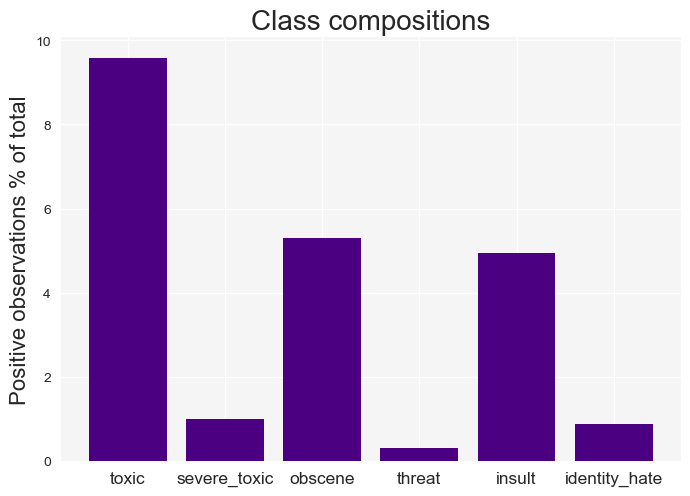

In [42]:
x_pos = [i for i, _ in enumerate(label_names)]
plt.style.use('seaborn')
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.bar(x_pos, class_proportions, color='indigo')
plt.ylabel("Positive observations % of total", fontsize=16)
plt.title("Class compositions", fontsize=20)
plt.xticks(x_pos, label_names, fontsize=12.5)

plt.show()

In [5]:
# Cleaning training data
print("Cleaning text in the training data...")
df["comment_text"].fillna("unknown", inplace=True)
df["comment_text"] = df["comment_text"].map(lambda x: remove_punct(x))
df["comment_text"] = df["comment_text"].map(lambda x: remove_URL(x))
df["comment_text"] = df["comment_text"].map(lambda x: remove_html(x))
df["comment_text"] = df["comment_text"].map(lambda x: remove_tokens(x))



Cleaning text in the training data...


In [8]:
comment_lengths = df.comment_text.str.len()
comment_lengths.mean(), comment_lengths.std(), comment_lengths.max()

(375.6670635641815, 564.9669141925596, 5000)

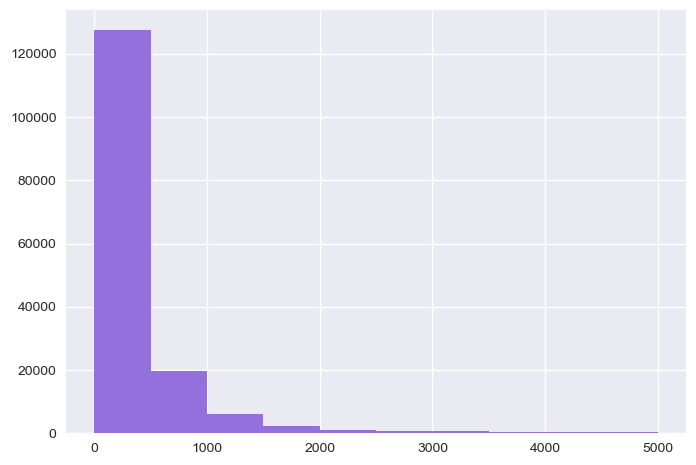

In [51]:

# plt.style.use('seaborn')

# ax = plt.gca()
# ax.set_facecolor('whitesmoke')
comment_lengths.hist(color='mediumpurple', label='Comment Length (chars) Histogram', histtype = 'bar')


In [6]:
# Converting comments into a sparse matrix of words
vectorizer = CountVectorizer(stop_words='english')
print("Vectorizing training features ...")
all_features = vectorizer.fit_transform(df.comment_text)

# Real test data
test_features_df = pd.read_csv("test.csv")
test_label_df = pd.read_csv("test_labels.csv")
test_combined_df = (pd.merge(test_features_df, test_label_df, left_on='id', right_on='id', how='left')) # Combining labels and features
test_combined_df = test_combined_df[(test_combined_df.toxic != -1)]  # Removing records with -1 tags
print("Cleaning text in the testing data...") # Cleaning testing data
test_combined_df["comment_text"].fillna("unknown", inplace=True)
test_combined_df["comment_text"] = test_combined_df["comment_text"].map(lambda x: remove_punct(x))
test_combined_df["comment_text"] = test_combined_df["comment_text"].map(lambda x: remove_URL(x))
test_combined_df["comment_text"] = test_combined_df["comment_text"].map(lambda x: remove_html(x))
test_combined_df["comment_text"] = test_combined_df["comment_text"].map(lambda x: remove_tokens(x))


print("Vectorizing testing features ...")
vectorizer = CountVectorizer(vocabulary=vectorizer.vocabulary_, stop_words='english')     # Using existing vector.vocabulary
test_features = vectorizer.transform(test_combined_df.comment_text)
test_labels = test_combined_df.drop(['id','comment_text'], axis=1)

Vectorizing training features ...
Cleaning text in the testing data...
Vectorizing testing features ...


<h1>The Classifiers<h1>

In [17]:
labels = df.drop(['id','comment_text'], axis=1)


In [28]:
labels.shape

(159571, 6)

In [114]:
np.array([labels.columns[0]]).shape

(1,)

In [70]:
MultiNBClassifiers = []
print("Building naive_bayes classifier for ",columnName, " category ...")
prior_negative = df[columnName].value_counts()[0]/df.shape[0]
prior_positive = 1- prior_negative
class_prior= [prior_negative, prior_positive]

validation_auc, validation_acc = fit_predict(
    all_features, labels.toxic, 'toxic', 
    MultinomialNB(class_prior=class_prior, fit_prior=True), 
    MultiNBClassifiers, 'Naive-bayes'
    )

Building naive_bayes classifier for  toxic  category ...
Training  toxic  category ...



In [71]:
validation_auc

94.5493221282959

Building naive_bayes classifier for  toxic  category ...
Training  toxic  category ...

Building naive_bayes classifier for  severe_toxic  category ...
Training  severe_toxic  category ...

Building naive_bayes classifier for  obscene  category ...
Training  obscene  category ...

Building naive_bayes classifier for  threat  category ...
Training  threat  category ...

Building naive_bayes classifier for  insult  category ...
Training  insult  category ...

Building naive_bayes classifier for  identity_hate  category ...
Training  identity_hate  category ...

Recall on toxic category =  52.5944 %
Confusion Matrix for toxic category
[[55991  1897]
 [ 2887  3203]]
Recall on severe_toxic category =  30.5177 %
Confusion Matrix for severe_toxic category
[[63010   601]
 [  255   112]]
Recall on obscene category =  46.8979 %
Confusion Matrix for obscene category
[[59183  1104]
 [ 1960  1731]]
Recall on threat category =  0.9479 %
Confusion Matrix for threat category
[[63453   314]
 [  209    

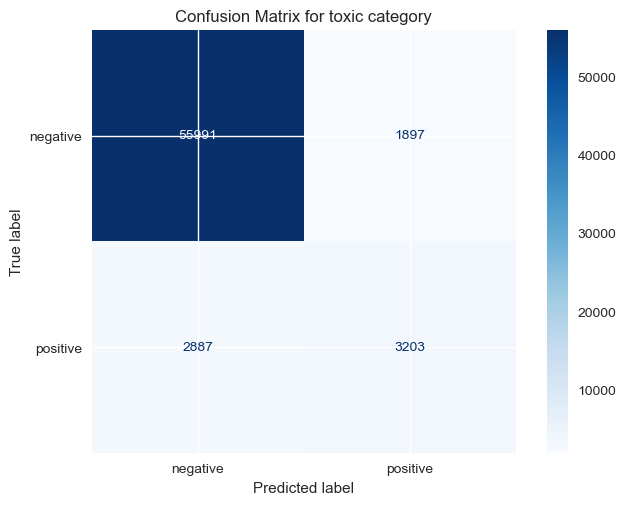

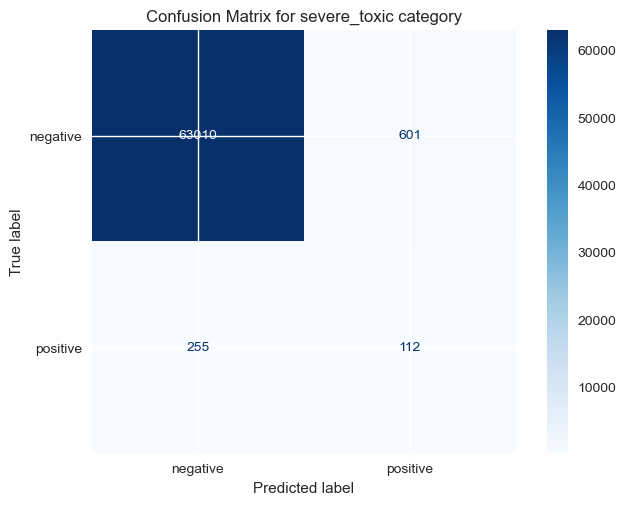

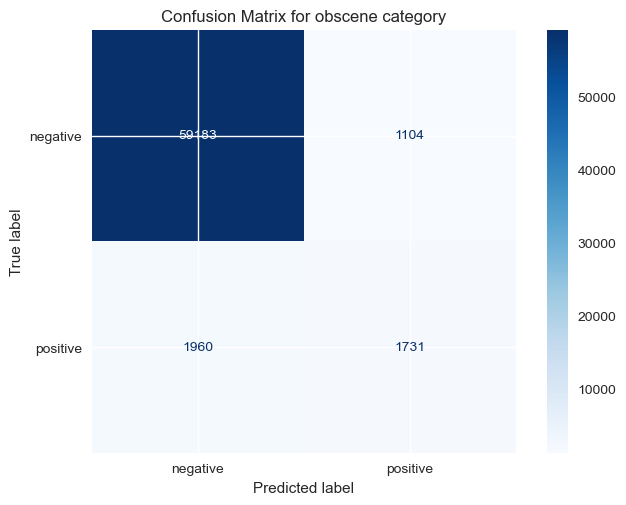

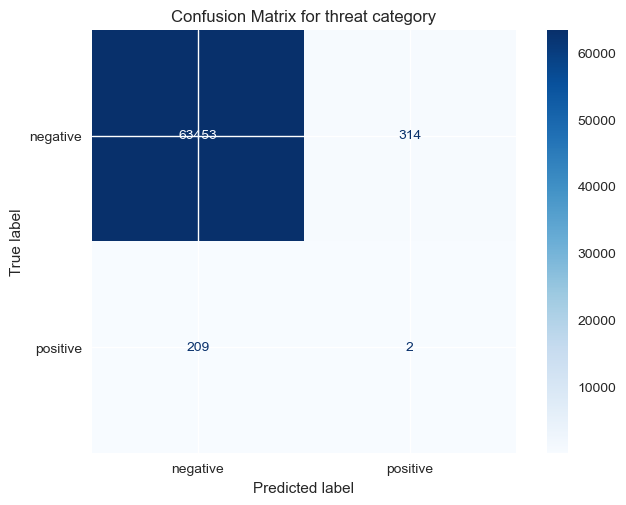

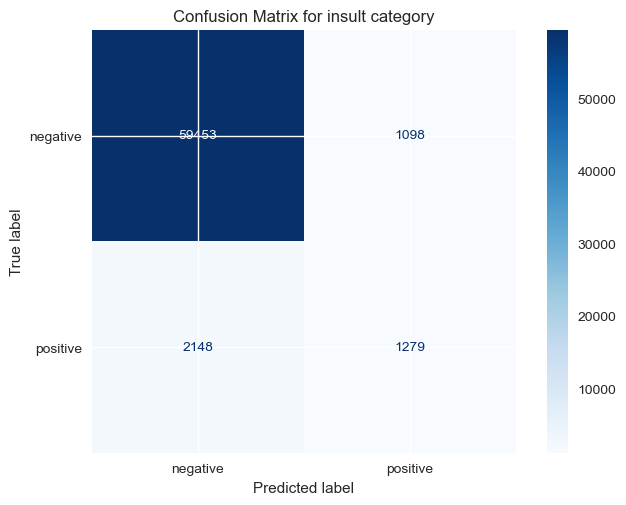

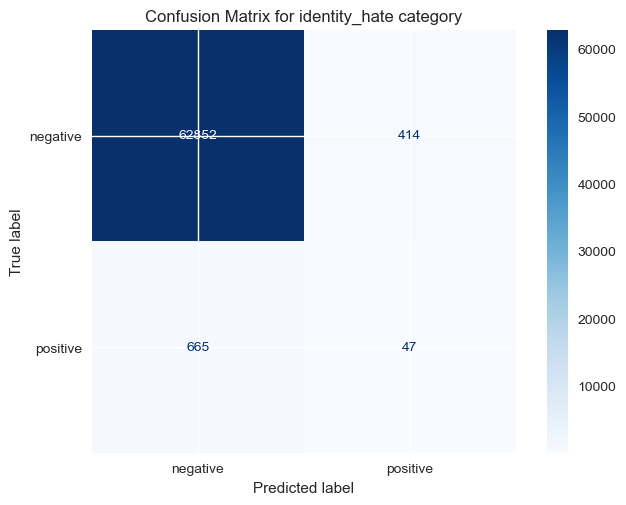

In [59]:
MultiNBClassifiers = []
i = 0
auc_total=0
acc_total=0

# Fitting and testing naive-bayes classifiers
for (columnName, columnData) in labels.iteritems():
    print("Building naive_bayes classifier for ",columnName, " category ...")
    prior_negative = df[columnName].value_counts()[0]/df.shape[0]
    prior_positive = 1- prior_negative
    class_prior= [prior_negative, prior_positive]
    validation_auc, validation_acc = fit_predict(
        all_features, columnData, columnName, 
        MultinomialNB(class_prior=class_prior, fit_prior=True), 
        MultiNBClassifiers, 'Naive-bayes'
        )
    auc_total+=validation_auc
    acc_total+=validation_acc

train_acc = (acc_total/6)*100
train_auc = (auc_total/6)
predict_score(MultiNBClassifiers, test_features, test_labels, train_auc, train_acc)

Recall on toxic category =  52.5944 %
Confusion Matrix for toxic category
[[0.96722982 0.03277018]
 [0.47405583 0.52594417]]
Recall on severe_toxic category =  30.5177 %
Confusion Matrix for severe_toxic category
[[0.99055195 0.00944805]
 [0.69482289 0.30517711]]
Recall on obscene category =  46.8979 %
Confusion Matrix for obscene category
[[0.98168759 0.01831241]
 [0.5310214  0.4689786 ]]
Recall on threat category =  0.9479 %
Confusion Matrix for threat category
[[0.99507582 0.00492418]
 [0.99052133 0.00947867]]
Recall on insult category =  37.3213 %
Confusion Matrix for insult category
[[0.98186653 0.01813347]
 [0.62678728 0.37321272]]
Recall on identity_hate category =  6.6011 %
Confusion Matrix for identity_hate category
[[0.9934562  0.0065438 ]
 [0.93398876 0.06601124]]
Validation auc_score of  Naive-bayes  =  51.7771 %
Validation accuracy of  Naive-bayes  =  97.0672 %
Testing auc_score of  Naive-bayes  =  51.9470 %
Testing recall of  Naive-bayes  =  42.2156 %
Testing accuracy of 

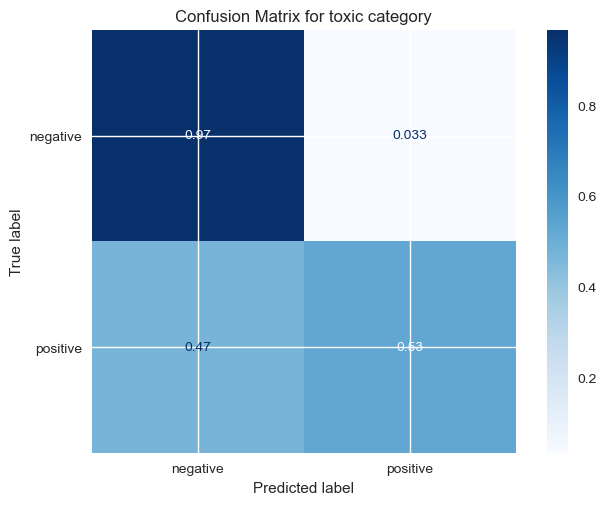

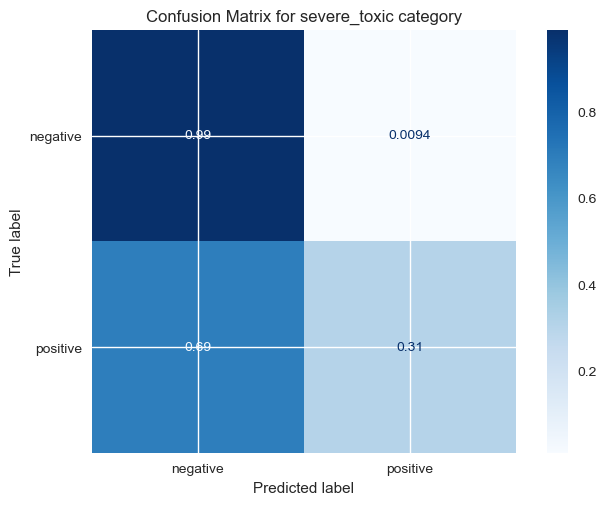

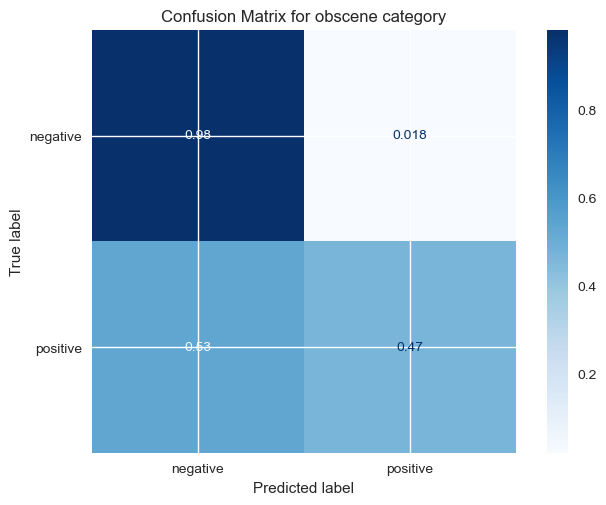

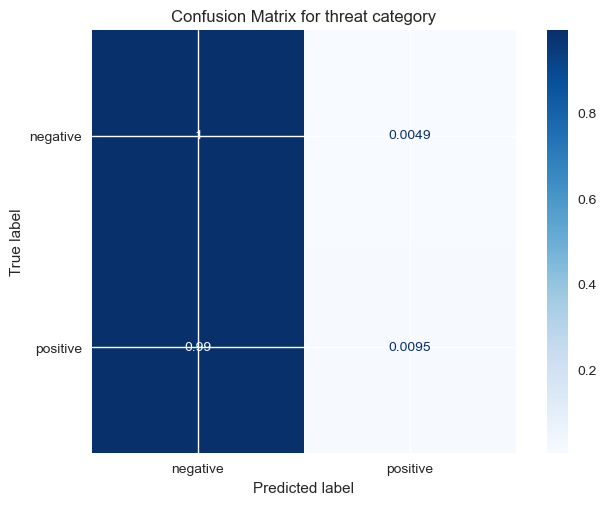

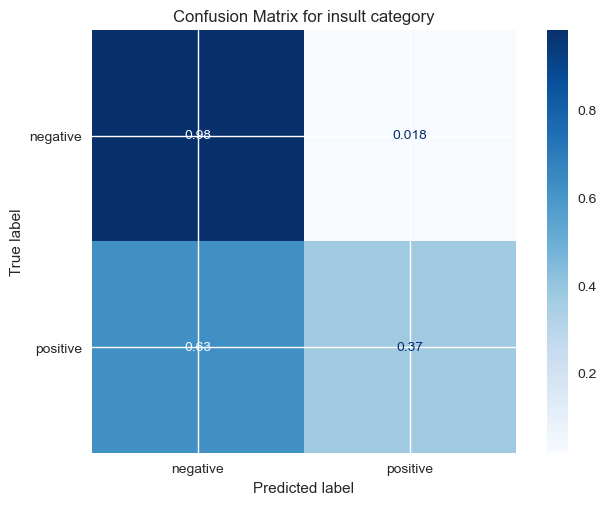

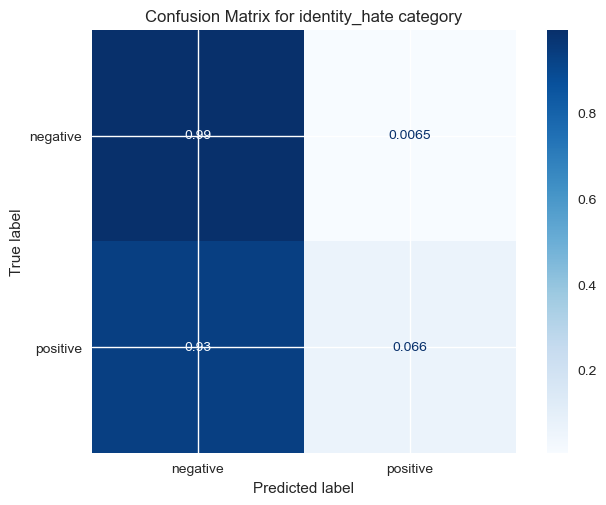

In [61]:
predict_score(MultiNBClassifiers, test_features, test_labels, train_auc, train_acc)

In [69]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

# Creating the
pipe = Pipeline([('classifier' , LogisticRegression())])

# Creating param grid.
param_grid = [
    {'classifier' : [LogisticRegression()],
    'classifier__C' : np.logspace(-4, 4, num=20),
    'classifier__solver' : ['liblinear'],
    'classifier__class_weight' :['balanced'],  
    'classifier__dual': [True],
    'classifier__max_iter': [100]}
]

# Create grid search object
clf = RandomizedSearchCV(pipe, param_distributions = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='roc_auc')



In [70]:
best_clf = clf.fit(all_features, labels.toxic)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished


In [71]:
clf.best_params_

{'classifier__solver': 'liblinear',
 'classifier__max_iter': 100,
 'classifier__dual': True,
 'classifier__class_weight': 'balanced',
 'classifier__C': 0.08858667904100823,
 'classifier': LogisticRegression(C=0.08858667904100823, class_weight='balanced', dual=True,
                    solver='liblinear')}

In [72]:
clf.best_score_

0.953905450400363

Building logistic regression classifier for  toxic  category ...
Training  toxic  category ...

Building logistic regression classifier for  severe_toxic  category ...
Training  severe_toxic  category ...

Building logistic regression classifier for  obscene  category ...
Training  obscene  category ...

Building logistic regression classifier for  threat  category ...
Training  threat  category ...

Building logistic regression classifier for  insult  category ...
Training  insult  category ...

Building logistic regression classifier for  identity_hate  category ...
Training  identity_hate  category ...

Recall on toxic category =  88.9819 %
Confusion Matrix for toxic category
[[0.879716   0.120284  ]
 [0.11018062 0.88981938]]
Recall on severe_toxic category =  88.8283 %
Confusion Matrix for severe_toxic category
[[0.96668815 0.03331185]
 [0.11171662 0.88828338]]
Recall on obscene category =  84.9092 %
Confusion Matrix for obscene category
[[0.93924063 0.06075937]
 [0.15090761 0.8490

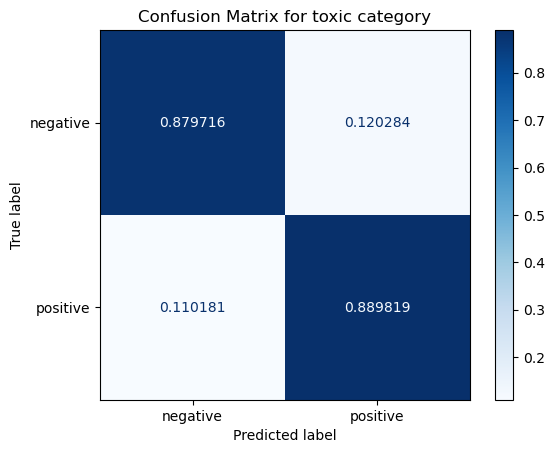

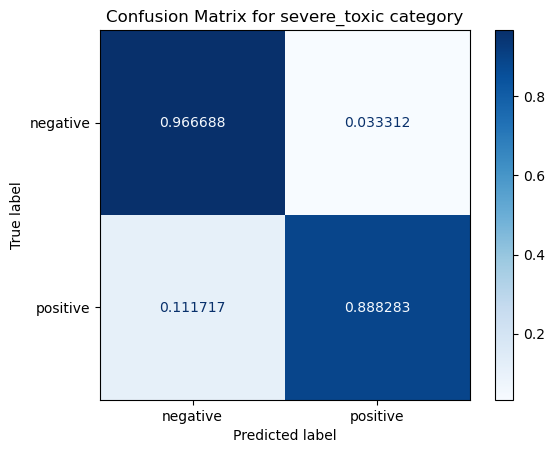

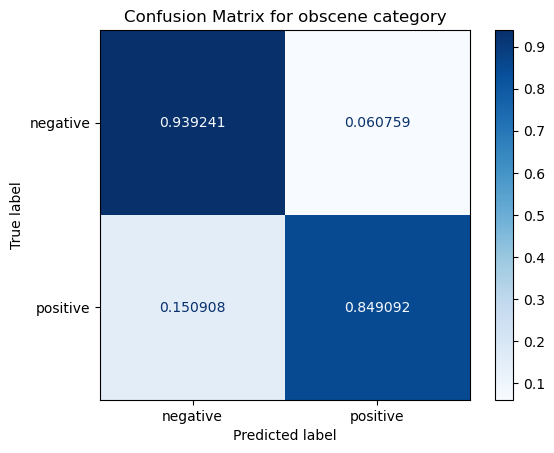

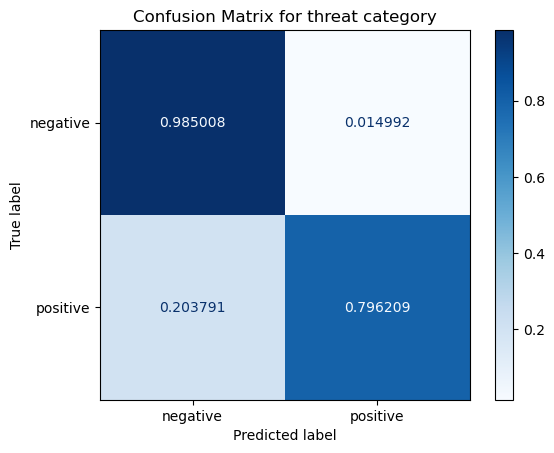

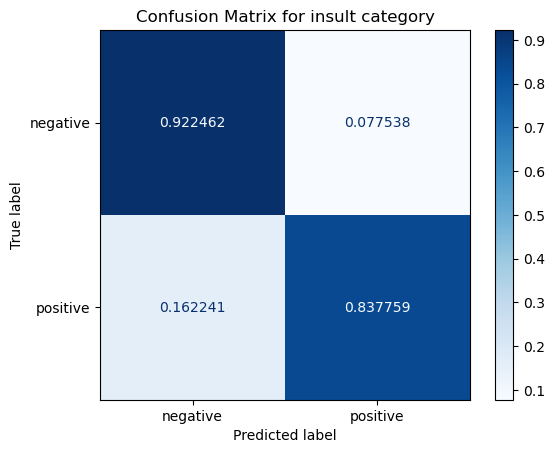

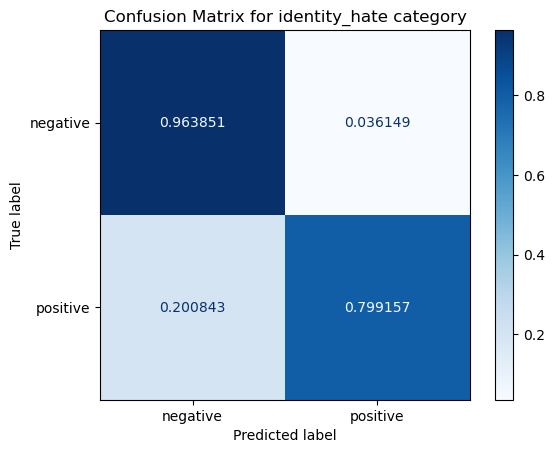

In [73]:
LogisticRegressionModels = []
i = 0
X_train, X_test, y_train, y_test = train_test_split(all_features, labels, test_size = 0.3, random_state=2)
auc_total=0
acc_total=0

# Optimal value for C: 0.08858667904100823
# Fitting and testing naive-bayes classifiers
for (columnName, columnData) in labels.iteritems():
    print("Building logistic regression classifier for ",columnName, " category ...")
    prior_negative = df[columnName].value_counts()[0]/df.shape[0]
    prior_positive = 1- prior_negative
    class_prior= [prior_negative, prior_positive]
    validation_auc, validation_acc = fit_predict(
        all_features, columnData, columnName, 
        LogisticRegression(C=0.08858667904100823, dual=True, solver='liblinear', max_iter=100, class_weight='balanced'), 
        LogisticRegressionModels, 'Logistic Regression'
        )
    auc_total+=validation_auc
    acc_total+=validation_acc

train_acc = (acc_total/6)*100
train_auc = (auc_total/6)
predict_score(LogisticRegressionModels, test_features, test_labels, train_auc, train_acc)


Recall on toxic category =  87.4056 %
Confusion Matrix for toxic category
[[0.89329395 0.10670605]
 [0.12594417 0.87405583]]
Recall on severe_toxic category =  77.6567 %
Confusion Matrix for severe_toxic category
[[0.97638773 0.02361227]
 [0.22343324 0.77656676]]
Recall on obscene category =  82.2270 %
Confusion Matrix for obscene category
[[0.95128303 0.04871697]
 [0.17772961 0.82227039]]
Recall on threat category =  72.5118 %
Confusion Matrix for threat category
[[0.98930481 0.01069519]
 [0.27488152 0.72511848]]
Recall on insult category =  77.9983 %
Confusion Matrix for insult category
[[0.94196628 0.05803372]
 [0.22001751 0.77998249]]
Recall on identity_hate category =  66.4326 %
Confusion Matrix for identity_hate category
[[0.97697025 0.02302975]
 [0.33567416 0.66432584]]
Validation auc_score of  Logistic Regression  =  51.7771 %
Validation accuracy of  Logistic Regression  =  97.0672 %
Testing auc_score of  Logistic Regression  =  50.9712 %
Testing recall of  Logistic Regression 

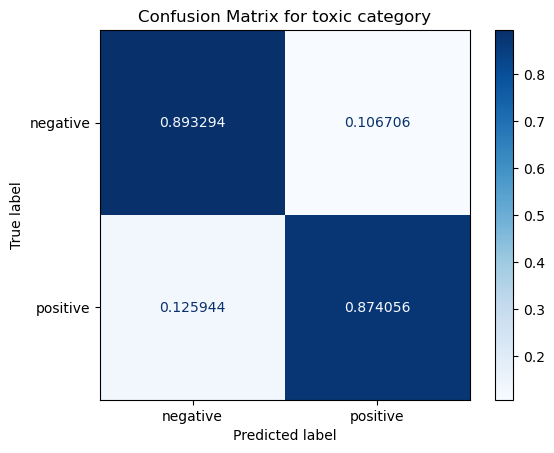

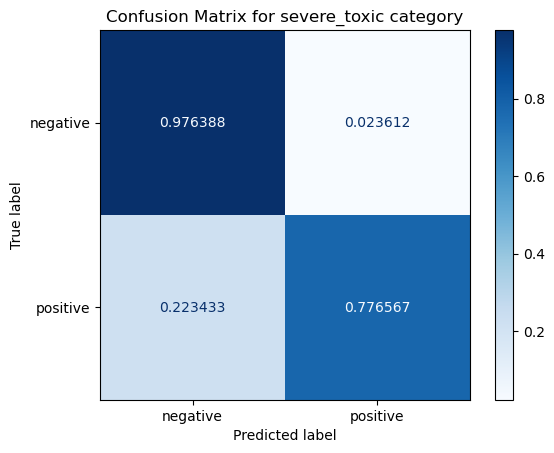

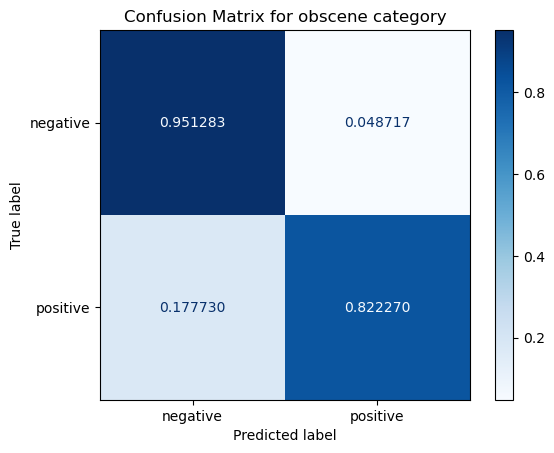

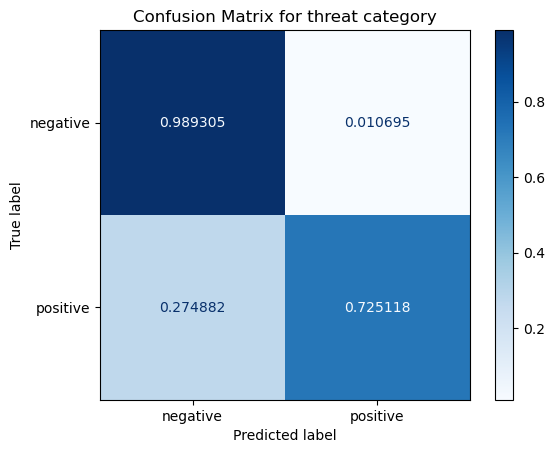

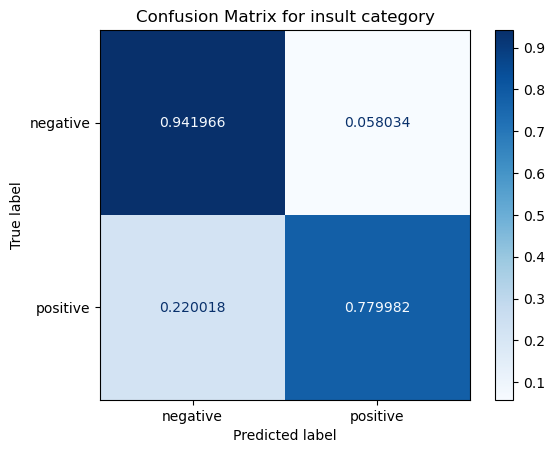

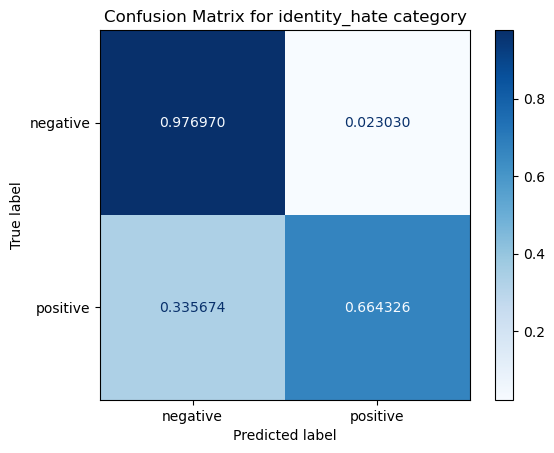

In [67]:
predict_score(LogisticRegressionModels, test_features, test_labels, train_auc, train_acc)


In [14]:
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


text = df.comment_text
comment_word_counts, vocab_counter = word_counter(text)
num_words = len(vocab_counter)
# Max number of words in a sequence - for keras
max_length = 60

In [15]:
print("Tokenizing training features ...")
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df.comment_text)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(df.comment_text)
train_padded = pad_sequences(
        train_sequences, maxlen=max_length, padding="post", truncating="post"
        )
        
print("Tokenizing testing features ...")
test_sequences = tokenizer.texts_to_sequences(test_combined_df.comment_text)
test_padded = pad_sequences(
    test_sequences, padding="post", truncating="post", maxlen=max_length
        )


Tokenizing training features ...
Tokenizing testing features ...


In [18]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Activation
import keras.backend as K
from keras.initializers import Constant
from keras.optimizers import Adam

# Getting biases and weights based on the distribution of the classes
# This is important due to the imbalance in the classes

biases, weights = init_params(labels)
biases = np.array(biases)

def bias_init(bias_shape, dtype='float64'):
    return K.variable(biases[:,0])

class_weights_dict = {0: weights[0],
            1: weights[1],
            2: weights[2],
            3: weights[3],
            4: weights[4],
            5: weights[5]}

n_outputs=6 # 6 possible categories in this multi-label classification
model = Sequential()
model.add(Embedding(num_words, 32, input_length=max_length))
model.add(LSTM(64, dropout=0.1))
model.add(Dense(n_outputs, activation="sigmoid", bias_initializer=bias_init))
optimizer = Adam(learning_rate=2e-3)
metrics=['accuracy',tf.keras.metrics.AUC(multi_label=True), tf.keras.metrics.FalsePositives()]

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)
print(model.summary())


Class toxic:
    Total: 159571
    Positive: 15294 (9.58% of total)

10.433568719759382

Class severe_toxic:
    Total: 159571
    Positive: 1595 (1.00% of total)

100.04451410658307

Class obscene:
    Total: 159571
    Positive: 8449 (5.29% of total)

18.886377086045687

Class threat:
    Total: 159571
    Positive: 478 (0.30% of total)

333.8305439330544

Class insult:
    Total: 159571
    Positive: 7877 (4.94% of total)

20.257839278913295

Class identity_hate:
    Total: 159571
    Positive: 1405 (0.88% of total)

113.57366548042704

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 32)            11401376  
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 6)

In [ ]:
history = model.fit(
train_padded, labels, epochs=4, validation_split=0.2, class_weight=class_weights_dict
)



In [ ]:
# Getting model predictions to build confusion matrices
test_pred = model.predict(test_padded)
test_pred_classes = (test_pred > 0.5).astype("int32")

# Model evaluation
model.evaluate(test_padded, test_labels)

In [ ]:
from sklearn.metrics import confusion_matrix
cm_list = []
i=0
for (columnName, columnData) in test_labels.iteritems():
  y_pred = test_pred_classes[:,i]
  cm = confusion_matrix(y_true=columnData, y_pred=y_pred, normalize='true')
  tnr, fpr, fnr, tpr = confusion_matrix(y_true=columnData, y_pred=y_pred, normalize='true').ravel()
  cm_list.append(cm)
  i+=1
  print(tnr, fpr, fnr, tpr)

In [ ]:
import itertools    

def plot_confusion_matrix(cm, classes,
                        normalize=True,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],4),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
title = 'Confusion Matrix for Toxic Category'
class_names = np.array(['negative', 'positive'])
i = 0

plot_confusion_matrix(cm_list[0], class_names, title=title,
                                cmap=plt.cm.Purples,
                                normalize=False)